In [1]:
import os
import glob
import gzip
import warnings

import pandas as pd
import rstoolbox
from libconfig.config import _get_repo
import matplotlib.pyplot as plt
import seaborn as sns

import make_sketches

warnings.filterwarnings('ignore')
rstoolbox.utils.format_Ipython()

# De novo design procedure for site 0 scaffold

## Template building

_De novo_ parametrically defined secondary structures were build exploiting a prototype library named [topobuilder](../bin/parametric/topobuilder.py) into a [custom made script](make_sketches.py) to create **three** distict parametric topologies around the neutralization epitope site 0, which was stabilized by an additional disulfide as in the template-based design [TBS0_39](link).

The script generated a _sketch_, a c-alpha only topology, and sequence from which constraints and fragments were derived. Both constraints and fragments were used to guide backbone folding with [FunFolDes](https://doi.org/10.1371/journal.pcbi.1006623).

In [2]:
GITROOT = _get_repo()
CWD = os.getcwd()

# Parametrically create the sketches
sketch_dir = make_sketches.main()

|**S0 epitope (extended)**|**bb1**|**bb2**|**bb3**|
|--------------|-------------|-------------|-------------|
|![epitope](README_files/epitope_parametric.gif)|![cf02](README_files/bb1_parametric.gif)|![cf00](README_files/bb2_parametric.gif)|![cf01](README_files/bb3_parametric.gif)|

## Template refolding and backbone selection

The sketches created are used to created C-alpha `atom_pair` constraints to use as input for Rosetta [FunFolDes](https://doi.org/10.1371/journal.pcbi.1006623).

By running FunFolDes, we obtain a continuous, unbroken topology that connects all the defined secondary structures while keeping the motif unmodified. Fragments for the protocol are created for each topology according to a secondary-structure based statisticall sequence.

After refolding, we observed several features that tilted the balance towards configuration **bb3** as the most likely to success. Observed features regarding this selection are:

* Arround 90% of all the rounds for **bb3** generated a backbone compatible with the expected constraints. This success drops to around a 30% for **bb2** and under 10% for **bb1**. This level of success can reflect on the viability of the topology.
* **bb3** is more successful in recover the disulfides at the edges of the S0 epitope, doubling the percentage of success of the following configuration **bb2**.
* After a initial naive design process, **bb3** backbone remains more static than the other two, indicating that the folded backboned better accomodate, as they are, a variate number of putative sequences.
* On _ab initio_ analysis of the top selected backbone, **bb3** presents a more coherent funnel than the other two.

In [3]:
# Create fragments from sequence (requires preparing the fragment database. See $GITROOT/resources/database)
for skd in sketch_dir:
    os.chdir(skd[0])
    cmd = '{} -in:file:vall {} -in:file:fasta {}'
    cmd = cmd.format(rstoolbox.utils.make_rosetta_app_path('fragment_picker'),
                     os.path.join(GITROOT, 'resources', 'database','vall.jul19.2011.gz'), 'sketch.fa')
    if not os.path.isfile('frag_1.200.3mers'):
        os.system(cmd)
    os.chdir(CWD)

# Create the RosettaScripts and SLURM submission files
header = ''.join(open(os.path.join(CWD, '..', 'bin', 'header.sh')).readlines()).format(500)
cmd = 'srun {} -parser:protocol {} -in:file:s {} -out:file:silent {}_${{SLURM_ARRAY_TASK_ID}} -nstruct 10 '
cmd += '-out:prefix {}_${{SLURM_ARRAY_TASK_ID}}_ -parser:script_vars insert=\'{}\' ss={}'
for skd in sketch_dir:
    os.chdir(skd[0])
    if not os.path.isfile('submit.sh'):
        cmdi = cmd.format(rstoolbox.utils.make_rosetta_app_path('rosetta_scripts'),
                          os.path.join('..', '..', 'bin', 'funfoldes.xml'),
                          os.path.join('..', 'epitope', 'site0_extended_center.pdb'),
                          'bbdesigns', 'bbdesigns', skd[1], skd[2])
        with open('submit.sh', 'w') as fd:
            fd.write(header + '\n')
            fd.write(cmdi)
        os.system('sbatch submit.sh')
    os.chdir(CWD)

In [4]:
# Join results into minisilents for storage/processing
for skd in sketch_dir:
    os.chdir(skd[0])
    infile = glob.glob('bbdesigns_*')
    ofile = 'bbdesigns.minisilent.gz'
    if not os.path.isfile(ofile):
        with gzip.open( ofile, "wb" ) as fd:
            for line, _, _, _ in rstoolbox.io.open_rosetta_file( infile, True, check_symmetry=False ):
                    fd.write( line.encode('utf-8') )
    os.chdir(CWD)

In [5]:
# Load designs for analysis
bb = []
for skd in sketch_dir:
    bb.append(rstoolbox.io.parse_rosetta_file(os.path.join(skd[0], 'bbdesigns.minisilent.gz'),
                                              {'scores': ['description', 'bbscore', 'evalCST',
                                                          'dslf_fa13', 'fold_evalCST'],
                                               'naming': ['', 'batch', 'site']}))
    bb[-1] = rstoolbox.utils.add_column(bb[-1], 'cfrm', skd[0])
bb = pd.concat(bb, ignore_index=True, sort=False)

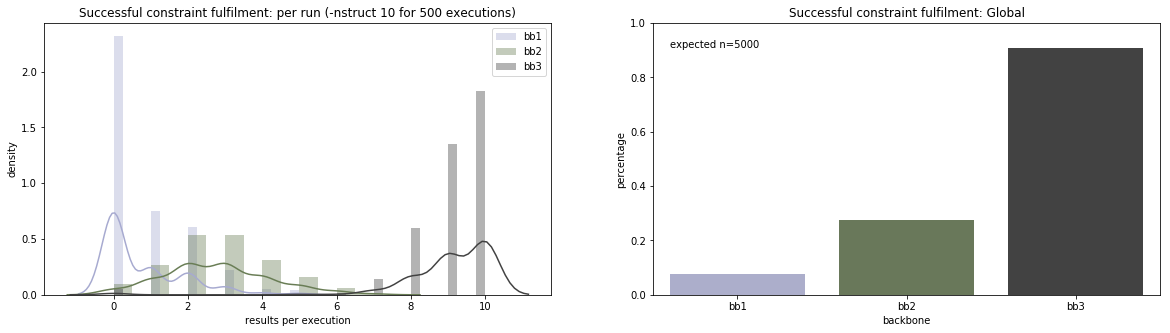

In [6]:
# Evaluate successful design per backbone alternative (bb) that fulfil within reason the expected constraints.
bbG = bb.groupby('cfrm')['batch'].value_counts().unstack(fill_value=0)
fig = plt.figure(figsize=(20, 5))
grid = (1, 2)
colors = ['#A7AAD0', '#697D55', '#424242']
axDP = plt.subplot2grid(grid, (0, 0))
for i in range(1, 4):
    sns.distplot(bbG.loc['bb{}'.format(i)], label='bb{}'.format(i), color=colors[i - 1], ax=axDP)
axDP.legend()
axDP.set_ylabel('density')
axDP.set_xlabel('results per execution')
axFL = plt.subplot2grid(grid, (0, 1))
bbG = (bbG.sum(axis=1) / 5000).reset_index()
sns.barplot(x='cfrm', y=0, data=bbG, ax=axFL, palette=colors)
axFL.set_ylabel('percentage')
axFL.set_xlabel('backbone')
axFL.set_ylim(0, 1)
axFL.text(-0.4, 0.9,'expected n=5000', horizontalalignment='left', verticalalignment='bottom')

axDP.set_title('Successful constraint fulfilment: per run (-nstruct 10 for 500 executions)')
axFL.set_title('Successful constraint fulfilment: Global')
plt.show()

In [7]:
# Abinitio is runned with structure-based fragments for a selected decoy in each backbone variant
# according to disulfide closure (dslf_fa13) backbone score (bbscore) and constraint fulfilment (evalCST)
ab = []
for skd in sketch_dir:
    ab.append(pd.read_csv(os.path.join(skd[0], 'abinitio', 'rmsd.abinitio'),
                          header=None, names=['score', 'rmsd'], sep=r'\s+'))
    ab[-1] = rstoolbox.utils.add_column(ab[-1], 'cfrm', skd[0])
ab = pd.concat(ab, ignore_index=True, sort=False)

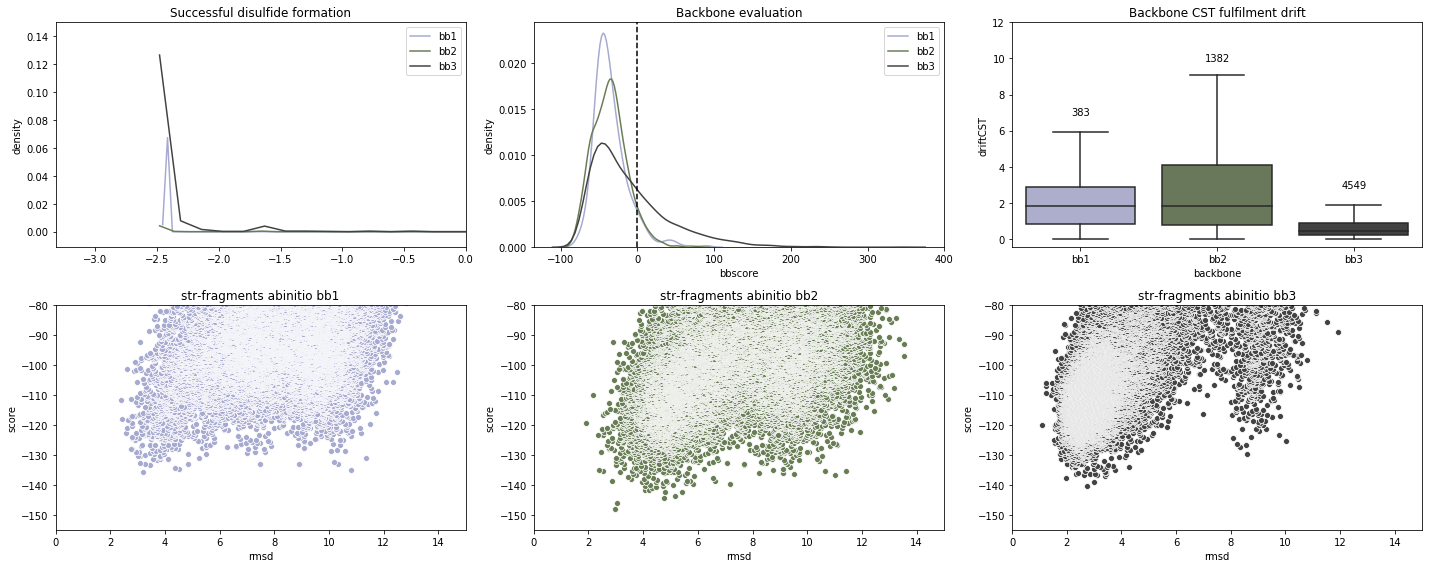

In [8]:
# Evaluation and selection of designable backbones
fig = plt.figure(figsize=(20, 8))
grid = (2, 3)
colors = ['#A7AAD0', '#697D55', '#424242']
ax = [plt.subplot2grid(grid, (0, 0)), plt.subplot2grid(grid, (0, 1)), plt.subplot2grid(grid, (0, 2)),
      plt.subplot2grid(grid, (1, 0)), plt.subplot2grid(grid, (1, 1)), plt.subplot2grid(grid, (1, 2))]

for i in range(1, 4):
    lbl = 'bb{}'.format(i)
    raw, y, x = rstoolbox.analysis.cumulative(bb[bb['cfrm'] == lbl]['dslf_fa13'].values, max_count=5000, cumulative=0)
    sns.lineplot(x, y, label=lbl, color=colors[i - 1], ax=ax[0])
ax[0].legend()
ax[0].set_ylabel('density')
ax[0].set_title('Successful disulfide formation')
#ax[0].axvline(0, 0, 5, color='black', linestyle='--')
ax[0].set_xlim(right=0)
ax[0].set_ylim(top=0.15)
for i in range(1, 4):
    lbl = 'bb{}'.format(i)
    sns.distplot(bb[bb['cfrm'] == lbl]['bbscore'], label=lbl, color=colors[i - 1], ax=ax[1], hist=False)
ax[1].legend()
ax[1].set_ylabel('density')
ax[1].set_title('Backbone evaluation')
ax[1].axvline(0, 0, 5, color='black', linestyle='--')

bbDRF = bb[['cfrm', 'fold_evalCST', 'evalCST']].copy()
bbDRF = bbDRF.assign(driftCST=abs(bbDRF['fold_evalCST'] - bbDRF['evalCST']))
sns.boxplot(x='cfrm', y='driftCST', data=bbDRF, showfliers=False, ax=ax[2], palette=colors)
ax[2].set_xlabel('backbone')
ax[2].set_ylim(top=12)
ax[2].set_title('Backbone CST fulfilment drift')
ax[2].text(0, 7, bbDRF[bbDRF['cfrm'] == 'bb1'].shape[0], horizontalalignment='center', verticalalignment='center')
ax[2].text(1, 10, bbDRF[bbDRF['cfrm'] == 'bb2'].shape[0], horizontalalignment='center', verticalalignment='center')
ax[2].text(2, 3, bbDRF[bbDRF['cfrm'] == 'bb3'].shape[0], horizontalalignment='center', verticalalignment='center')

bbCYD = bb[(bb['dslf_fa13'] < 0) & (bb['bbscore'] < 0)]
for i in range(3):
    config = 'bb{:d}'.format(i + 1)
    sns.scatterplot(x='rmsd', y='score', data=ab[(ab['cfrm'] == config) & (ab['score'] < 50)], ax=ax[i + 3],
                    color=colors[i])
    ax[i + 3].set_title('str-fragments abinitio ' + config)
    ax[i + 3].set_ylim(-155, -80)
    ax[i + 3].set_xlim(0, 15)
plt.tight_layout()
plt.show()

## Sequence design of selected topology

Results from backbone folding suggested **bb3** as the one with a higher chance of success. As such, a selected backbone from the population was diversified through flexible backbone design.

The RosettaScript for design is provided [here](design/design_helical_topology.xml). Scoring during the design process is guided by a [weights file](design/talaris2014_highAlanine.wts) that penalizes alanines during the design process, which was required to increase the fraction of residues with larger hydrophobic side chains for improved core packing. Sequences were selected according to multiple parameters, selection criteria are detailed here.

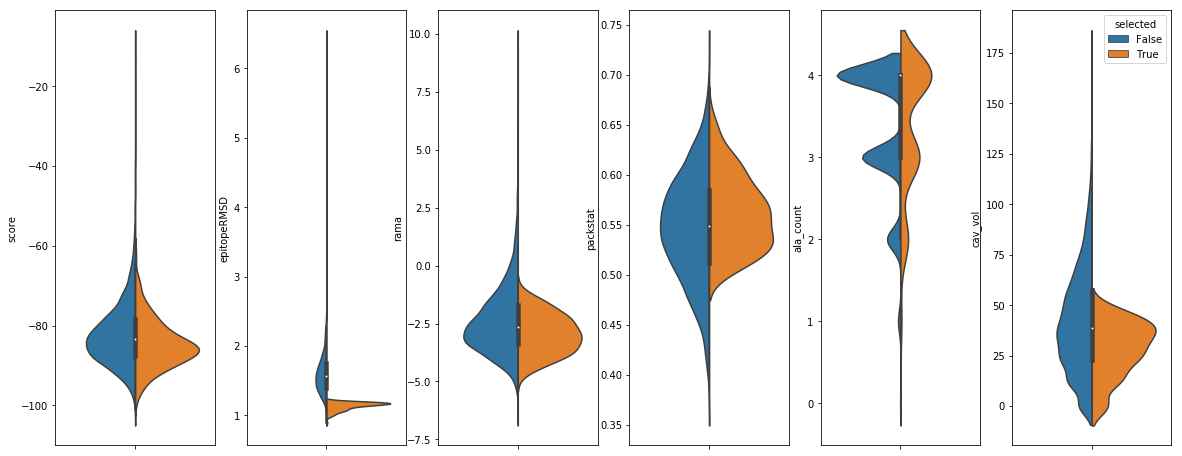

In [9]:
dsg = rstoolbox.io.parse_rosetta_file('design/bb3_designs.minisilent.gz', 
                                      {'scores': ['score', 'epitopeRMSD', 'rama', 'packstat',
                                                  'ala_count', 'cav_vol', 'description'],
                                       'naming': ['', 'bb']})
# Filter and pick
pck = dsg[(dsg["epitopeRMSD"] < 1.2) & (dsg["packstat"] > 0.5) &
          (dsg["rama"] < -1.0) & (dsg["cav_vol"] <50)].sort_values(["packstat"], ascending=False)
dsg = dsg.assign(selected=dsg['description'].isin(pck['description']))

# Show
fig = plt.figure(figsize=(20, 8))
grid = (1, 6)
props = ['score', 'epitopeRMSD', 'rama', 'packstat', 'ala_count', 'cav_vol']
for i in range(6):
    ax = plt.subplot2grid(grid, (0, i))
    sns.violinplot(x='bb', y=props[i], hue='selected', data=dsg, split=True, ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels([''])
    if i < 5:
        ax.get_legend().remove()
plt.show()

The almost 200 structure obtained through this filtering process can be found [here](design/selected).

Following manual inspection, sequences were encoded in oligo libraries, and screened using yeast display, which re-expanded the sequence space explored.